

# Web Server Log Analysis with Apache Spark**
 
 
Server log analysis is an ideal use case for Spark.  It's a very large, common data source and contains a rich set of information.  Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them.   Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content, and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

But first I need to start Spark. In this case on local machine.

In [1]:
from pyspark import SparkConf, SparkContext

## Module Constants
APP_NAME = "CTR"

## Closure Functions
nodes = "local[" + str(2*12) + "]"
executorMemory = "2g"
conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster("local[*]")
conf = conf.set("spark.executor.memory",executorMemory)   
   
sc   = SparkContext(conf=conf)
print "number of nodes: " + nodes  + "   executorMemory: "+ executorMemory

number of nodes: local[24]   executorMemory: 2g


### Apache Web Server Log file format**
####The log file that I use are in the [Apache Common Log Format (CLF)](http://httpd.apache.org/docs/1.3/logs.html#common). The log file entries produced in CLF will look something like this:
`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`
 
####Each part of this log entry is described below.
* `127.0.0.1`
####This is the IP address (or host name, if available) of the client (remote host) which made the request to the server.
 
* `-`
####The "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.
 
* `-`
####The "hyphen" in the output indicates that the requested piece of information (user identity from local logon) is not available.
 
* `[01/Aug/1995:00:00:01 -0400]`
####The time that the server finished processing the request. The format is:
`[day/month/year:hour:minute:second timezone]`
  * ####day = 2 digits
  * ####month = 3 letters
  * ####year = 4 digits
  * ####hour = 2 digits
  * ####minute = 2 digits
  * ####second = 2 digits
  * ####zone = (\+ | \-) 4 digits
 
* `"GET /images/launch-logo.gif HTTP/1.0"`
####This is the first line of the request string from the client. It consists of a three components: the request method (e.g., `GET`, `POST`, etc.), the endpoint (a [Uniform Resource Identifier](http://en.wikipedia.org/wiki/Uniform_resource_identifier)), and the client protocol version.
 
* `200`
####This is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification ([RFC 2616](https://www.ietf.org/rfc/rfc2616.txt) section 10).
 
* `1839`
####The last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).
 
### NASA-HTTP Web Server Log
####I will use a data set from NASA Kennedy Space Center WWW server in Florida. The full data set is freely available (http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html).

In [2]:
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

### **Configuration and Initial RDD Creation**
####I am ready to specify the input log file and create an RDD containing the parsed log file data. 
 
####To create the primary RDD that I will use in the rest of this assignment, we first load the text file using [`sc.textfile(logFile)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.textFile) to convert each line of the file into an element in an RDD.
####Next, I use [`map(parseApacheLogLine)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map) to apply the parse function to each element (that is, a line from the log file) in the RDD and turn each line into a pair [`Row` object](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Row).
####Finally, I cache the RDD in memory since I will use it throughout this notebook.

In [5]:
import sys
import os
#from test_helper import Test


logFile = os.path.join('sparkdata', 'NASA_access_log_Jul95')

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline: 864
Invalid logline: 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid logline: nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid logline: ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Invalid logline: gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid logline: s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid logline: pipe3.nyc.pipeline.com 

In [6]:
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline: 849
Invalid logline: 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid logline: nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid logline: ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Invalid logline: gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid logline: s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid logline: pipe3.nyc.pipeline.com 

In [7]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())

Content Size Avg: 20464, Min: 0, Max: 6823936


In [8]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList
#assert len(responseCodeToCountList) == 7
#assert sorted(responseCodeToCountList) == [(200, 940847), (302, 16244), (304, 79824), (403, 58), (404, 6185), (500, 2), (501, 17)]

Found 7 response codes
Response Code Counts: [(302, 46569), (304, 132626), (500, 62), (200, 1700757), (403, 54), (501, 14), (404, 10784)]


In [9]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[302, 304, 500, 200, 403, 501, 404]
[0.02462839778175714, 0.07014034839063159, 3.278920875408411e-05, 0.8994592953704811, 2.8558343108395834e-05, 7.404014879954476e-06, 0.00570320689038779]


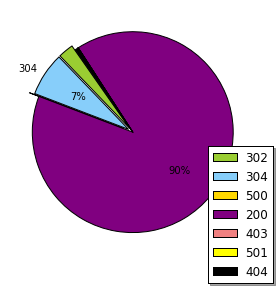

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

#replace with bar chart, pi charts are distracting visualizations
def pie_pct_format(value):
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

In [11]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20
# An example: [u'204.120.34.185', u'204.243.249.9', u'slip1-32.acs.ohio-state.edu', u'lapdog-14.baylor.edu', u'199.77.67.3', u'gs1.cs.ttu.edu', u'haskell.limbex.com', u'alfred.uib.no', u'146.129.66.31', u'manaus.bologna.maraut.it', u'dialup98-110.swipnet.se', u'slip-ppp02.feldspar.com', u'ad03-053.compuserve.com', u'srawlin.opsys.nwa.com', u'199.202.200.52', u'ix-den7-23.ix.netcom.com', u'151.99.247.114', u'w20-575-104.mit.edu', u'205.25.227.20', u'ns.rmc.com']

Any 20 hosts that have accessed more then 10 times: [u'calvert.psc.rochester.edu', u'sl137.active.ch', u'slip104-134.mn.us.ibm.net', u'corning.cat.rpi.edu', u'sjackson.seanet.com', u'194.20.34.29', u'mischka.csn.tu-chemnitz.de', u'anp10.intercon.net', u'philly13.voicenet.com', u'128.158.55.143', u'pm2-01.magicnet.net', u'198.70.210.51', u'user.40.169.dcccd.edu', u'ginec01.unimo.it', u'gs1.cs.ttu.edu', u'wilma.netinfo.com.au', u'165.164.140.189', u'jabrown.remote.ualberta.ca', u'dialup96-033.swipnet.se', u'pckcb1.cad.ksc.nasa.gov']


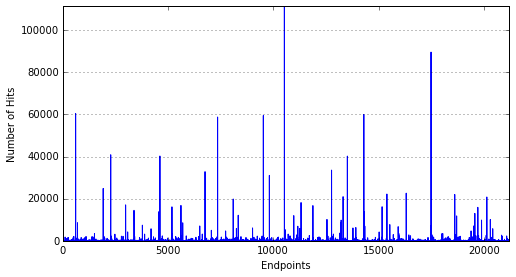

In [12]:
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
pass

In [13]:
# Top Endpoints
endpointCounts = (access_logs
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print 'Top Ten Endpoints: %s' % topEndpoints
#assert topEndpoints == [(u'/images/NASA-logosmall.gif', 59737), (u'/images/KSC-logosmall.gif', 50452), (u'/images/MOSAIC-logosmall.gif', 43890), (u'/images/USA-logosmall.gif', 43664), (u'/images/WORLD-logosmall.gif', 43277), (u'/images/ksclogo-medium.gif', 41336), (u'/ksc.html', 28582), (u'/history/apollo/images/apollo-logo1.gif', 26778), (u'/images/launch-logo.gif', 24755), (u'/', 20292)], 'incorrect Top Ten Endpoints'

Top Ten Endpoints: [(u'/images/NASA-logosmall.gif', 111331), (u'/images/KSC-logosmall.gif', 89639), (u'/images/MOSAIC-logosmall.gif', 60468), (u'/images/USA-logosmall.gif', 60014), (u'/images/WORLD-logosmall.gif', 59489), (u'/images/ksclogo-medium.gif', 58802), (u'/images/launch-logo.gif', 40871), (u'/shuttle/countdown/', 40279), (u'/ksc.html', 40226), (u'/images/ksclogosmall.gif', 33585)]


In [1]:
from pyspark import SparkConf, SparkContext

## Module Constants
APP_NAME = "CTR"

## Closure Functions
nodes = "local[" + str(2*12) + "]"
executorMemory = "2g"
conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster("local[*]")
conf = conf.set("spark.executor.memory",executorMemory)   
   
sc   = SparkContext(conf=conf)
print "number of nodes: " + nodes  + "   executorMemory: "+ executorMemory

number of nodes: local[24]   executorMemory: 2g


In [14]:
# Top Ten Error Endpoints

not200 = access_logs.filter(lambda log: (log.response_code !=200 ))

endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a, b : a + b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1 * s[1])
print 'Top Ten failed URLs: %s' % topTenErrURLs


Top Ten failed URLs: [(u'/images/NASA-logosmall.gif', 21010), (u'/images/KSC-logosmall.gif', 12435), (u'/images/MOSAIC-logosmall.gif', 6628), (u'/images/USA-logosmall.gif', 6577), (u'/images/WORLD-logosmall.gif', 6413), (u'/images/ksclogo-medium.gif', 5837), (u'/images/launch-logo.gif', 4628), (u'/shuttle/countdown/liftoff.html', 3509), (u'/shuttle/countdown/', 3345), (u'/shuttle/countdown/images/cdtclock.gif', 3251)]


In [15]:
# Number of Unique Hosts
hosts = access_logs.map(lambda log: log.host)

uniqueHosts = hosts.distinct()

uniqueHostCount = len(uniqueHosts.collect())
print 'Unique hosts: %d' % uniqueHostCount


Unique hosts: 81971


In [16]:
# Number of Unique Daily Hosts
dayToHostPairTuple = access_logs.map(lambda log: (log.date_time.day,log.host))

dayGroupedHosts = (dayToHostPairTuple.groupByKey().map(lambda pr: (pr[0],list(set(pr[1])))).cache())

dayHostCount = dayGroupedHosts.map(lambda pa: (pa[0],len(pa[1])))

dailyHosts = (dayHostCount.reduceByKey(lambda a, b : a + b).cache())

dailyHostsList = dailyHosts.takeOrdered(30, lambda s:  s[0])
print 'Unique hosts per day: %s' % dailyHostsList

Unique hosts per day: [(1, 5192), (2, 4859), (3, 7335), (4, 5522), (5, 7382), (6, 7819), (7, 6473), (8, 2897), (9, 2553), (10, 4464), (11, 4924), (12, 5345), (13, 6951), (14, 5296), (15, 3116), (16, 3012), (17, 4943), (18, 4522), (19, 4918), (20, 4727), (21, 4339), (22, 2575), (23, 2635), (24, 4297), (25, 4376), (26, 4296), (27, 4368), (28, 2175)]


In [17]:
# Visualizing the Number of Unique Daily Hosts

daysWithHosts = dailyHosts.sortByKey().map(lambda pa: pa[0]).collect()
hosts = dailyHosts.sortByKey().map(lambda pa: pa[1]).collect()

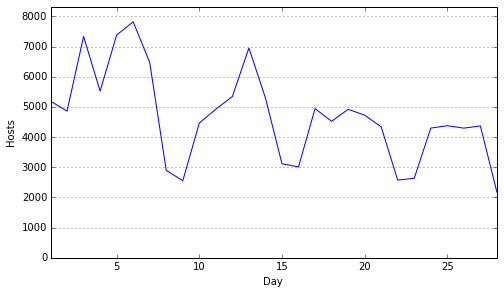

In [19]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)
pass

In [20]:
# Average Number of Daily Requests per Hosts
dayAndHostTuple = access_logs.map(lambda log: (log.date_time.day,log.host))

groupedByDay = dayAndHostTuple.groupByKey()


sortedByDay = groupedByDay.sortByKey()

avgDailyReqPerHost = (sortedByDay.map(lambda pr: (pr[0],len(pr[1])/len(list(set(pr[1]))))).cache())

avgDailyReqPerHostList = avgDailyReqPerHost.take(30)
print 'Average number of daily requests per Hosts is %s' % avgDailyReqPerHostList


Average number of daily requests per Hosts is [(1, 12), (2, 12), (3, 12), (4, 12), (5, 12), (6, 12), (7, 13), (8, 13), (9, 13), (10, 16), (11, 16), (12, 17), (13, 19), (14, 15), (15, 14), (16, 15), (17, 15), (18, 14), (19, 14), (20, 14), (21, 14), (22, 13), (23, 14), (24, 14), (25, 14), (26, 13), (27, 14), (28, 12)]


In [21]:
# Visualizing the Average Daily Requests per Unique Host

daysWithAvg = avgDailyReqPerHost.map(lambda pa: pa[0]).collect()
avgs = avgDailyReqPerHost.map(lambda pa: pa[1]).collect()


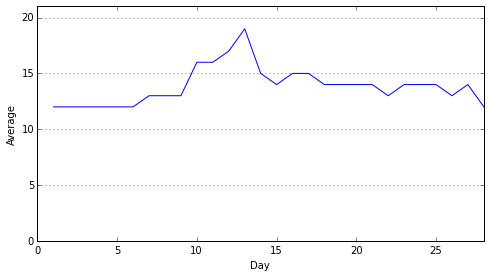

In [22]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
pass

In [23]:
# How many 404 records are in the log?

badRecords = (access_logs.filter(lambda log: (log.response_code == 404 )).cache())

print 'Found %d 404 URLs' % badRecords.count()

Found 10784 404 URLs


In [24]:
#  Listing 404 Response Code Records
badEndpoints = badRecords.map(lambda log: log.endpoint)
badUniqueEndpoints = badEndpoints.distinct()
badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print '404 URLS: %s' % badUniqueEndpointsPick40

404 URLS: [u'/dir', u'/psm/propst.html', u'/shuttle/missions/sts-70/movies/movies.htm/', u'/shuttle/missions/sts-71/images/KSC-95EC-0965jpg', u'/facts/http:www.disney.com', u'/ntv/', u'/shuttle/technology/ml', u'/shuttle/mission/sts-70/', u'/pub/winvn/winvn.html', u'/shuttle/missions/sts-68/mission-sts-63.html', u'/history/apollo/sa-5/movies/', u'/wxworld/images/IMAGE6pNgmSfc/95072712_06.GIF', u'/shuttle/technology/sts-newsref/et.html#et', u'/images/nasausa.gif', u'/shuttle/missions/sts-70/images/inages.html', u'/shuttle/technology/sts-newsref/centers.html#sts-ksc-ov-mating', u'/history/apollo/apollo.html\\', u'/HISTORY/APOLLO/APOLLO-13/APOLLO-12.HTML', u'/software/winvn/winvin.html', u'/daily/esc/', u'/history/apollo/sa-6/images/', u'/history/apollo/apollo-13/apol', u'/shuttle/news/sci.space.news/705', u'/history/appolo/apollo-13.html', u'/bonsai/jpop/profiles/jpopbiog.html', u'/shuttle/technology/sts-newsref/sts_egress.html#sts_bio', u'/shuttle/technology/sts-newsref/stsover-prep.hmt

In [25]:
# Listing the Top Twenty 404 Response Code Endpoints

badEndpointsCountPairTuple = badRecords.map(lambda log: (log.endpoint,1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda a, b : a + b)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20, lambda s: -1 * s[1])
print 'Top Twenty 404 URLs: %s' % badEndpointsTop20

Top Twenty 404 URLs: [(u'/pub/winvn/readme.txt', 667), (u'/pub/winvn/release.txt', 547), (u'/history/apollo/apollo-13.html', 286), (u'/shuttle/resources/orbiters/atlantis.gif', 232), (u'/history/apollo/a-001/a-001-patch-small.gif', 230), (u'/://spacelink.msfc.nasa.gov', 215), (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 215), (u'/images/crawlerway-logo.gif', 214), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 183), (u'/shuttle/resources/orbiters/discovery.gif', 180), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 175), (u'/shuttle/missions/sts-71/images/KSC-95EC-0916.txt', 168), (u'/elv/DELTA/uncons.htm', 163), (u'/history/apollo/publications/sp-350/sp-350.txt~', 140), (u'/shuttle/missions/technology/sts-newsref/stsref-toc.html', 107), (u'/shuttle/resources/orbiters/challenger.gif', 92), (u'/procurement/procurement.htm', 86), (u'/history/apollo-13/apollo-13.html', 73), (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 71), (u'/shuttle/coun

In [26]:
# Listing the Top Twenty-five 404 Response Code Hosts


errHostsCountPairTuple = badRecords.map(lambda log: (log.host,1))

errHostsSum = errHostsCountPairTuple.reduceByKey(lambda a, b : a + b)

errHostsTop25 = errHostsSum.takeOrdered(25, lambda s: -1 * s[1])
print 'Top 25 hosts that generated errors: %s' % errHostsTop25

Top 25 hosts that generated errors: [(u'hoohoo.ncsa.uiuc.edu', 251), (u'jbiagioni.npt.nuwc.navy.mil', 131), (u'piweba3y.prodigy.com', 110), (u'piweba1y.prodigy.com', 92), (u'phaelon.ksc.nasa.gov', 64), (u'www-d4.proxy.aol.com', 61), (u'monarch.eng.buffalo.edu', 56), (u'piweba4y.prodigy.com', 56), (u'alyssa.prodigy.com', 54), (u'titan02f', 53), (u'www-a2.proxy.aol.com', 52), (u'www-b4.proxy.aol.com', 48), (u'www-b6.proxy.aol.com', 44), (u'www-b3.proxy.aol.com', 43), (u'tearnest2.stpaul.ncr.com', 42), (u'www-b2.proxy.aol.com', 41), (u'www-d1.proxy.aol.com', 41), (u'www-a1.proxy.aol.com', 38), (u'piweba2y.prodigy.com', 38), (u'www-d3.proxy.aol.com', 38), (u'scooter.pa-x.dec.com', 34), (u'proxy.austin.ibm.com', 34), (u'www-d2.proxy.aol.com', 33), (u'www-b5.proxy.aol.com', 32), (u'unotv.unomaha.edu', 31)]


In [27]:
#  Listing 404 Response Codes per Day

errDateCountPairTuple = badRecords.map(lambda log: (log.date_time.day,1))

errDateSum = errDateCountPairTuple.reduceByKey(lambda a, b : a + b)

errDateSorted = (errDateSum.sortByKey() .cache())

errByDate = errDateSorted.collect()
print '404 Errors by day: %s' % errByDate

404 Errors by day: [(1, 315), (2, 289), (3, 474), (4, 357), (5, 495), (6, 636), (7, 566), (8, 299), (9, 348), (10, 395), (11, 470), (12, 462), (13, 525), (14, 412), (15, 253), (16, 257), (17, 405), (18, 463), (19, 639), (20, 428), (21, 334), (22, 182), (23, 233), (24, 327), (25, 460), (26, 331), (27, 335), (28, 94)]


In [28]:
# Visualizing the 404 Response Codes by Day
daysWithErrors404 = errDateSorted.map(lambda pa: pa[0]).collect()
errors404ByDay = errDateSorted.map(lambda pa: pa[1]).collect()

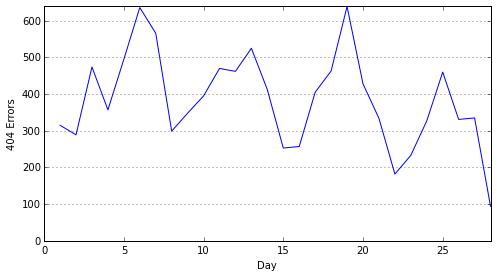

In [29]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)
pass

#### **(4g) Exercise: Top Five Days for 404 Response Codes **
####Using the RDD `errDateSorted` you cached in the part (4e), what are the top five days for 404 response codes and the corresponding counts of 404 response codes?

In [30]:
# TODO: Replace <FILL IN> with appropriate code

topErrDate = errDateSorted.takeOrdered(5, lambda s: -1 * s[1])
print 'Top Five dates for 404 requests: %s' % topErrDate

Top Five dates for 404 requests: [(19, 639), (6, 636), (7, 566), (13, 525), (5, 495)]


In [31]:
#  Hourly 404 Response Codes

hourCountPairTuple = badRecords.map(lambda log: (log.date_time.hour,1))

hourRecordsSum = hourCountPairTuple.reduceByKey(lambda a, b : a + b)

hourRecordsSorted = (hourRecordsSum.sortByKey().cache())

errHourList = hourRecordsSorted.collect()
print 'Top hours for 404 requests: %s' % errHourList

Top hours for 404 requests: [(0, 428), (1, 320), (2, 268), (3, 240), (4, 167), (5, 146), (6, 134), (7, 239), (8, 363), (9, 480), (10, 589), (11, 728), (12, 650), (13, 530), (14, 750), (15, 831), (16, 630), (17, 617), (18, 498), (19, 410), (20, 381), (21, 442), (22, 483), (23, 460)]


In [32]:
# Visualizing the 404 Response Codes by Hour

hoursWithErrors404 = hourRecordsSorted.map(lambda pa: pa[0]).collect()
errors404ByHours = hourRecordsSorted.map(lambda pa: pa[1]).collect()

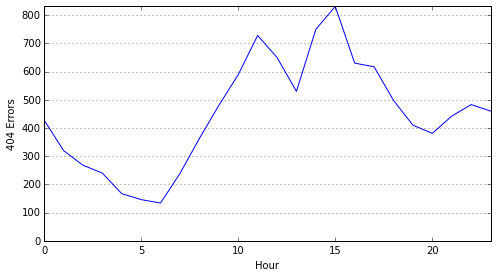

In [33]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
pass